In [75]:
import urllib
import urllib.request
import json

import pandas as pd
import numpy as np

In [23]:
binance_base = "https://<>.binance.com"
binance_subdomains = ["api", "api1", "api2", "api3"]

binance_url = binance_base.replace('<>', binance_subdomains[0])

binance_endpoints = {
    'ping': ('GET', '/api/v3/ping'),
    'server_time': ('GET', '/api/v3/time'),
    'exchange_info': ('GET', '/api/v3/exchangeInfo'),
    'order_book': ('GET', '/api/v3/depth', {'symbol': True, 'limit': False}),
    'recent_trades': ('GET', '/api/v3/trades', {'symbol': True, 'limit': False}),
    'average_price': ('GET', '/api/v3/avgPrice', {'symbol': True}),
    'price': ('GET', '/api/v3/ticker/price', {'symbol': False}),
    'best_book_price': ('GET', '/api/v3/ticker/bookTicker', {'symbol': False})
}

In [35]:
binance_uri = binance_url + binance_endpoints['exchange_info'][1]

web_url = urllib.request.urlopen(binance_uri)
data = web_url.read()
encoding = web_url.info().get_content_charset('utf-8')
JSON_object = json.loads(data.decode(encoding))

df_symbols = pd.DataFrame(JSON_object['symbols'])
df_symbols = df_symbols[df_symbols['status']=='TRADING']

In [2]:
# market cap
binance_uri = "https://www.binance.com/exchange-api/v2/public/asset-service/product/get-products"
web_url = urllib.request.urlopen(binance_uri)
data = web_url.read()
encoding = web_url.info().get_content_charset('utf-8')
JSON_object = json.loads(data.decode(encoding))
df_market = pd.DataFrame(JSON_object['data'])
df_market['c'] = df_market['c'].astype(float)
df_market['market_cap'] = df_market['cs'].fillna(0).astype(float)*df_market['c'].fillna(0)
df_market = df_market[df_market['market_cap']>0]
df_market.sort_values(by='market_cap', ascending=False)

,s,st,b,q,ba,qa,i,ts,an,qn,...,y,as,pm,pn,cs,tags,pom,pomt,etf,market_cap
185,BTCBIDR,TRADING,BTC,BIDR,฿,,0.00000100,1,Bitcoin,BIDR,...,0,86.177251,FIAT,FIAT,1.867246e+07,"[pow, mining-zone]",False,None,False,1.581367e+16
191,BTCIDRT,TRADING,BTC,IDRT,฿,,0.00000100,1,Bitcoin,Rupiah Token,...,0,4.603756,FIAT,FIAT,1.867246e+07,"[pow, mining-zone]",False,None,False,1.562939e+16
377,ETHBIDR,TRADING,ETH,BIDR,Ξ,,0.00001000,1,Ethereum,BIDR,...,0,1168.975230,FIAT,FIAT,1.153187e+08,"[pow, mining-zone]",False,None,False,3.438402e+15
849,USDTBVND,TRADING,USDT,BVND,,,0.01000000,1,TetherUS,BVND,...,0,783655.590000,FIAT,FIAT,4.230975e+10,[],False,None,False,1.037985e+15
166,BNBBIDR,TRADING,BNB,BIDR,,,0.00100000,1,BNB,BIDR,...,0,24521.364000,FIAT,FIAT,1.526659e+08,"[pos, mining-zone, BSC]",False,None,False,8.802480e+14


<AxesSubplot:>

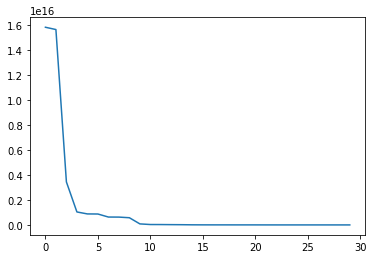

In [21]:
df_market['market_cap'].sort_values(ascending=False).reset_index(drop=True)[:30].plot()

In [53]:
import asyncio
import aiohttp
from aiohttp import ClientSession

async def get_symbol_trades_stats(symbol):
    binance_uri = binance_url + binance_endpoints['recent_trades'][1] + f'?symbol={symbol}'
    async with ClientSession() as session:
        res = await session.request(method="GET", url=binance_uri)
        res_json = await res.text()
        JSON_object = json.loads(res_json)
    df_recent_trades = pd.DataFrame(JSON_object)
    mean_time = df_recent_trades['time'].diff().mean()
    return mean_time

In [54]:
result = []

for sym in df_symbols['symbol'].to_list():
    res = await get_symbol_trades_stats(sym)
    result.append({'symbol': sym, 'average_trade_time': res})
    
df_trade_times = pd.DataFrame(result)

df_trade_times['market_cap'] = np.NaN
df_market_caps = df_market.set_index('s').loc[df_trade_times[df_trade_times['symbol'].isin(df_market['s'])]['symbol'], 'market_cap']
market_caps = df_market_caps.values
idx = df_market_caps.index

df_trade_times = df_trade_times.set_index('symbol')
df_trade_times.loc[idx, 'market_cap'] = market_caps

<AxesSubplot:xlabel='symbol'>

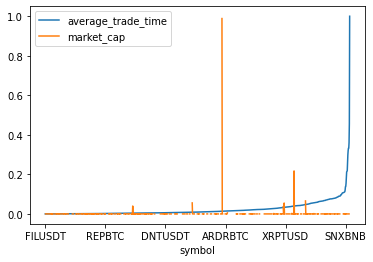

In [117]:
df_trade_times.sort_values('average_trade_time').apply(lambda x: x/x.max(), axis=0).plot()

<AxesSubplot:xlabel='symbol'>

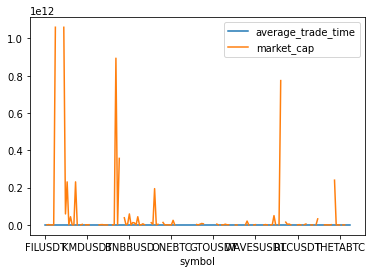

In [131]:
df_trade_times[df_trade_times['average_trade_time']<1000].sort_values('average_trade_time').plot()